### Construct Kinematic Chain using `networkx` package

In [16]:
import copy
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from util import r2rpy,rpy2r,rodrigues
from networkx.algorithms.traversal.depth_first_search import dfs_edges
np.set_printoptions(precision=2)
%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("networkx version:[%s]"%(nx.__version__))

networkx version:[3.1]


### Manually construct a kinematic chain

In [17]:
class KinematicChainClass(object):
    def __init__(self,name='Kinematic Chain'):
        """
            Initialize Kinematic Chain Object
        """
        self.name        = name 
        self.chain       = None
        self.joint_names = []
        # Initialize chain
        self.init_chain()
        
    def init_chain(self):
        """
            Initialize chain
        """
        if self.chain is not None:
            self.chain.clear()
        self.chain = nx.DiGraph(name=self.name)
        
    def get_n_joint(self):
        """
            Get the number of joints
        """
        return self.chain.number_of_nodes()
    
    def get_joint_idx(self,joint_name):
        """
            Get the index of a joint
        """
        joint_idx = self.joint_names.index(joint_name)
        return joint_idx
    
    def get_joint_idxs(self,joint_names):
        """
            Get the indices of joints 
        """
        joint_idxs = [[idx for idx,item in enumerate(self.joint_names) 
                       if item==joint_name] for joint_name in joint_names]
        return joint_idxs

    def add_joint(self,name='',a=np.array([0,0,0]),
                  p=np.zeros(3),R=np.eye(3),
                  p_offset=np.zeros(3),R_offset=np.eye(3),
                  parent_name=None):
        """
            Add joint to the chain
        """
        # Add new node (=joint)
        new_joint_idx = self.get_n_joint()
        self.chain.add_node(new_joint_idx)
        
        # Update joint information
        joint_info = {'name':name,'p':p,'R':R,'q':0.0,
                      'a':a,'p_offset':p_offset,'R_offset':R_offset,
                      'parent':[],'childs':[]}
        self.chain.update(nodes=[(new_joint_idx,joint_info)])
        
        # Append joint name
        self.joint_names.append(name)
        
        # Add parent 
        if parent_name is not None:
            # Add parent index
            parent_idx = self.get_joint_idx(parent_name)
            self.chain.nodes[new_joint_idx]['parent'] = parent_idx
            # Connect parent and child
            self.chain.add_edge(u_of_edge=parent_idx,v_of_edge=new_joint_idx)
        
        # Append childs to the parent
        parent_idx = self.get_joint_idx(name)
        parent_childs = self.chain.nodes[parent_idx]['childs']
        parent_childs.append(new_joint_idx)
        
    def get_joint(self,joint_idx):
        """
            Get joint in tree
        """
        joint = self.chain.nodes[joint_idx]
        return joint
    
    def update_joint_info(self,joint_idx,key,value):
        """
            Update joint information 
        """
        self.chain.nodes[joint_idx][key] = value
        
    def forward_kinematics(self):
        """
            Forward Kinematics
        """
        for idx,edge in enumerate(dfs_edges(self.chain,source=0)):
            idx_fr   = edge[0]
            idx_to   = edge[1]
            joint_fr = self.get_joint(idx_fr)
            joint_to = self.get_joint(idx_to)
            # Update p
            p = joint_fr['R']@joint_to['p_offset'] + joint_fr['p']
            self.update_joint_info(idx_to,'p',p)
            # Update R
            a_to = joint_to['a']
            if abs(np.linalg.norm(a_to)-1) < 1e-6: # with axis
                q_to = joint_to['q']
                R = joint_fr['R']@joint_to['R_offset']@rodrigues(a=a_to,q=q_to)
            else:
                R = joint_fr['R']@joint_to['R_offset']
            self.update_joint_info(idx_to,'R',R)
    
    
    def print_chain_info(self):
        """
            Print chain information
        """
        n_joint = self.get_n_joint()
        for j_idx in range(n_joint):
            joint = self.get_joint(joint_idx=j_idx)
            print ("[%d/%d] joint name:[%s] p:%s rpy_deg:%s"%
                   (j_idx,n_joint,joint['name'],
                    joint['p'],
                    np.degrees(r2rpy(joint['R']))
                   ))
        
    def plot_chain_graph(self,align='horizontal',figsize=(6,4),
                   node_size=300,font_size=10,
                   ROOT_ON_TOP=True):
        """
            Plot chain graph
        """
        tree = self.chain
        for layer, nodes in enumerate(nx.topological_generations(tree)):
            for node in nodes:
                tree.nodes[node]['layer'] = layer
        pos = nx.multipartite_layout(tree,align=align,
                                     scale=1.0,subset_key='layer')
        # Invert the tree so that the root node comes on the top
        if ROOT_ON_TOP:
            pos = {node: (x, -y) for node, (x, y) in pos.items()} 
        # Plot
        fig,ax = plt.subplots(figsize=figsize)
        nx.draw_networkx(tree,pos=pos,ax=ax,with_labels=True,
                         node_size=node_size,font_size=font_size,node_color='w',
                         linewidths=1,edgecolors='k')
        ax.set_title('%s'%(tree.name))
        fig.tight_layout()
        plt.show()
        
print ("Ready.")        

Ready.


### Initialize kinematic chain

In [28]:
KC = KinematicChainClass(name='Kinematic Chain')
KC.add_joint(name='World',p=np.array([1,2,3]),R=rpy2r(np.radians([0,90,0])))
KC.add_joint(name='Joint1',parent_name='World',
             p_offset=np.array([0,0,1]),R_offset=rpy2r(np.radians([90,0,0])))
KC.add_joint(name='Joint2',parent_name='Joint1',
             p_offset=np.array([0,0,1]),R_offset=rpy2r(np.radians([0,90,0])))
KC.add_joint(name='Joint3',parent_name='Joint2',
             p_offset=np.array([0,0,1]),R_offset=rpy2r(np.radians([0,90,0])))
KC.add_joint(name='Joint4',parent_name='Joint3',
             p_offset=np.array([0,0,1]),R_offset=rpy2r(np.radians([0,0,0])))

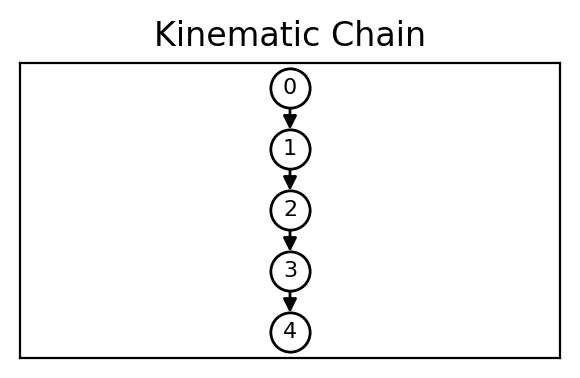

In [29]:
# Plot chain
KC.plot_chain_graph(figsize=(3,2),node_size=200,font_size=8)

In [30]:
KC.print_chain_info()

[0/5] joint name:[World] p:[1 2 3] rpy_deg:[ 0. 90.  0.]
[1/5] joint name:[Joint1] p:[0. 0. 0.] rpy_deg:[ 0. -0.  0.]
[2/5] joint name:[Joint2] p:[0. 0. 0.] rpy_deg:[ 0. -0.  0.]
[3/5] joint name:[Joint3] p:[0. 0. 0.] rpy_deg:[ 0. -0.  0.]
[4/5] joint name:[Joint4] p:[0. 0. 0.] rpy_deg:[ 0. -0.  0.]


### Forward Kinematics

In [31]:
KC.forward_kinematics()

In [32]:
KC.print_chain_info()

[0/5] joint name:[World] p:[1 2 3] rpy_deg:[ 0. 90.  0.]
[1/5] joint name:[Joint1] p:[2. 2. 3.] rpy_deg:[90. 90.  0.]
[2/5] joint name:[Joint2] p:[2. 1. 3.] rpy_deg:[1.80e+02 3.51e-15 9.00e+01]
[3/5] joint name:[Joint3] p:[2. 1. 2.] rpy_deg:[153.43 -90.   116.57]
[4/5] joint name:[Joint4] p:[2. 2. 2.] rpy_deg:[153.43 -90.   116.57]
